In [15]:
# !pip install pyvista[jupyter]

In [16]:
import numpy as np
import pyvista as pv
from bruges import attribute
from scipy.ndimage import label, center_of_mass

import matplotlib.pyplot as plt

pv.set_jupyter_backend("trame")

In [17]:
cube_full = np.load("../data/processed/F3_seismic.npy")
print("Форма куба:", cube_full.shape)

# Выбираем фрагмент, где ожидаем аномалии
# Ось 0 (651) → xline-like → [200, 400]
# Ось 1 (951) → iline-like → [300, 600]
# Ось 2 (462) → время → [300, 450] (нижняя часть = большие времена)
subcube = cube_full[200:400, 300:600, 300:450]

print("Фрагмент:", subcube.shape)

# # Нормализация
# subcube_norm = (subcube - np.mean(subcube)) / (3 * np.std(subcube))
# subcube_norm = np.clip(subcube_norm, -1, 1)

Форма куба: (651, 951, 462)
Фрагмент: (200, 300, 150)


In [18]:
# Нормализация
subcube_norm = (subcube - subcube.mean()) / (2 * subcube.std())
subcube_norm = np.clip(subcube_norm, -1.5, 1.5)

# --------------------------------------------------
# 2. ВЫДЕЛЕНИЕ АНОМАЛИЙ
# --------------------------------------------------
envelope = np.abs(attribute.envelope(subcube_norm))
threshold = np.mean(envelope) + 2.5 * np.std(envelope)
anomaly_mask = envelope > threshold

print(f"Аномальных вокселей: {anomaly_mask.sum()}")

# --------------------------------------------------
# 3. ПОДГОТОВКА СЕТОК
# --------------------------------------------------
grid = pv.ImageData()
grid.dimensions = np.array(subcube_norm.shape) + 1
grid.cell_data["Amplitude"] = subcube_norm.flatten(order="F")

grid_anomaly = pv.ImageData()
grid_anomaly.dimensions = np.array(anomaly_mask.shape) + 1
grid_anomaly.cell_data["Anomaly"] = anomaly_mask.astype(np.float32).flatten(
    order="F"
)
contours = grid_anomaly.cell_data_to_point_data().contour([0.5])

# --------------------------------------------------
# 4. ВИЗУАЛИЗАЦИЯ: СИЛЬНО ПРОЗРАЧНЫЙ КУБ
# --------------------------------------------------
plotter = pv.Plotter(window_size=[1200, 800])

# 🔹 ОЧЕНЬ ПРОЗРАЧНЫЙ КУБ
plotter.add_volume(
    grid,
    scalars="Amplitude",
    cmap="seismic",
    opacity="sigmoid_6",
    # opacity=[0.0, 0.05, 0.1, 0.2],
    # opacity=[0.0, 0.0, 0.0, 0.0],
    blending="composite",
)

# 🔸 ЯРКАЯ АНОМАЛИЯ
if contours.n_points > 0:
    plotter.add_mesh(
        contours,
        color="yellow",  # стандарт для bright spots
        opacity=0.9,  # почти непрозрачная
        smooth_shading=True,
        label="Bright Spot",
    )

# Оформление
plotter.show_axes()
plotter.add_title("Сейсмический куб", font_size=12)
plotter.camera_position = "iso"

plotter.show()

Аномальных вокселей: 311844


Widget(value='<iframe src="http://localhost:43657/index.html?ui=P_0x78ace1718b00_2&reconnect=auto" class="pyvi…

In [19]:
# plotter.screenshot("seismic_3d.png", scale=2)  # масштаб 2x для высокого DPI

In [20]:
print("Число аномальных вокселей:", anomaly_mask.sum())
if anomaly_mask.sum() == 0:
    print("⚠️ Нет аномалий! Попробуйте уменьшить порог.")

Число аномальных вокселей: 311844


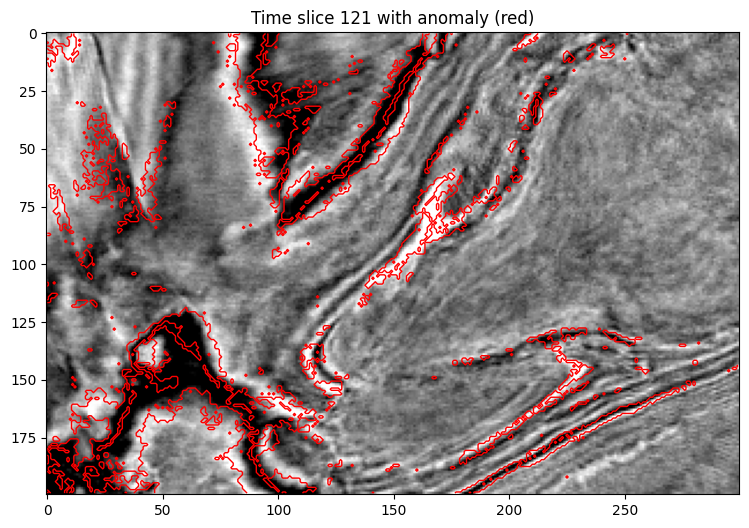

In [21]:
# Пример: срез по времени, где аномалия максимальна
time_idx = np.argmax(envelope.mean(axis=(0, 1)))
plt.figure(figsize=(10, 6))
plt.imshow(subcube_norm[:, :, time_idx], cmap="gray")
plt.contour(anomaly_mask[:, :, time_idx], colors="red", linewidths=1)
plt.title(f"Time slice {time_idx} with anomaly (red)")
plt.show()